# Task A — Feasibility Prediction Model
**Climate Resilience Fund — Decision-Support Prototype**

This notebook builds a model to predict whether a climate-resilience intervention will be delivered on time, given district characteristics, hazard data, and intervention parameters.

**Outputs:** `dist_int_delivery.csv` — predicted delivery probability for every district × intervention pair (used by Task B).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import json, os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    roc_auc_score, brier_score_loss, average_precision_score,
    classification_report, roc_curve, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GridSearchCV

In [ ]:
#Give path to the inputs files. The data provided for the case study is stored in the "data" folder under "dalberg_case_study" folder
DATA = "/content/drive/MyDrive/dalberg_case_study"

---
## 1. Load Data

In [ ]:
#read all the inputs files in the data folder
districts = pd.read_csv(f"{DATA}/data/district_profile.csv")
hazard = pd.read_csv(f"{DATA}/data/hazard_timeseries.csv")
projects = pd.read_csv(f"{DATA}/data/project_history.csv")
interventions = pd.read_csv(f"{DATA}/data/interventions_catalog.csv")
field_index = pd.read_csv(f"{DATA}/data/field_notes_index.csv")

print(f"Districts:      {districts.shape}")
print(f"Hazard:         {hazard.shape}")
print(f"Projects:       {projects.shape}")
print(f"Interventions:  {interventions.shape}")
print(f"Field Index:    {field_index.shape}")

Districts:      (120, 17)
Hazard:         (5752, 9)
Projects:       (2400, 17)
Interventions:  (18, 10)
Field Index:    (90, 10)


---
## 2. Data Exploration

In [ ]:
print("── District Profiles ──")
display(districts.head())
print(f"\nShape: {districts.shape}")
print(f"Missing values:\n{districts.isnull().sum()[districts.isnull().sum() > 0]}")

── District Profiles ──


,district_id,district_code,district_name,country,region,lat,lon,population,poverty_index,urbanization_rate,baseline_infrastructure_index,health_access_index,mobile_penetration,grid_reliability_index,historical_flood_loss_usd,historical_heat_loss_usd,past_programs_count
0,D001,D-001,District 001,Azuria,West,7.5686,32.2731,482439,0.712,0.392,0.501,0.470,0.538,0.373,193381236,177290296,2
1,D002,D-002,District 002,Belvaria,Central,-4.6765,30.6633,1276594,0.545,0.407,0.400,0.532,0.652,0.562,512042463,305436955,1
2,D003,D-003,District 003,Belvaria,South,-4.6603,27.5657,69911,0.219,0.494,0.819,0.565,0.675,0.702,14849309,12194380,4
3,D004,D-004,District 004,Azuria,South,5.3975,25.6303,888928,0.341,0.063,0.842,0.550,0.843,0.567,167017490,109091348,4
4,D005,D-005,District 005,Azuria,South,7.5488,36.2640,574657,0.536,0.346,0.468,0.511,0.646,0.500,173055338,60400475,1



Shape: (120, 17)
Missing values:
health_access_index    4
mobile_penetration     4
dtype: int64


In [ ]:
print("── Project History ──")
display(projects.head())
print(f"\nShape: {projects.shape}")
print(f"\nLabel distribution (delivered_on_time):")
print(projects['delivered_on_time'].value_counts())
print(f"On-time rate: {projects['delivered_on_time'].mean():.1%}")

── Project History ──


,project_id,district_code,intervention_id,partner,start_date,planned_end_date,actual_end_date,cost_usd,baseline_risk_score,total_delay_days,achieved_outcome_score,realized_risk_reduction,delivered_on_time,achieved_min_outcome,community_engagement_score,post_project_audit_score,post_project_satisfaction_score
0,P00001,D-059,I13,Delta Engineering,2023-01-12,2024-09-03,2024-11-02,984200,61.81,60,76.92,0.326,0,1,52.12,71.23,71.25
1,P00002,D-030,I11,HydroBuild Co,2023-03-12,2024-05-05,2024-08-14,849300,67.10,101,59.22,0.146,0,0,37.86,57.78,52.29
2,P00003,D-013,I10,CivicResilience NGO,2023-01-15,2024-02-09,2024-02-18,383200,55.16,9,64.78,0.218,1,1,52.79,70.12,55.28
3,P00004,D-058,I06,HydroBuild Co,2023-07-20,2025-02-09,2025-03-21,518500,70.79,40,64.72,0.477,1,1,50.41,67.48,55.11
4,P00005,D-020,I18,RapidRelief Local,2023-07-13,2025-03-04,2025-06-05,864600,58.10,93,66.58,0.266,0,1,44.03,67.09,52.95



Shape: (2400, 17)

Label distribution (delivered_on_time):
delivered_on_time
0    2144
1     256
Name: count, dtype: int64
On-time rate: 10.7%


In [ ]:
print("── Interventions Catalog ──")
display(interventions)
print(f"\nHazard focus breakdown:")
print(interventions['hazard_focus'].value_counts())

── Interventions Catalog ──


,intervention_id,intervention_name,hazard_focus,unit_cost_usd,expected_risk_reduction_mean,expected_risk_reduction_low,expected_risk_reduction_high,implementation_months,complexity_1_5,prerequisites
0,I01,Drainage Rehabilitation (Basic),flood,969000,0.120,0.076,0.176,13,3,NaN
1,I02,River Embankment Reinforcement (Standard),flood,1263000,0.149,0.106,0.213,14,2,Community consultation
2,I03,Flood Shelter Retrofit (Enhanced),flood,638000,0.240,0.184,0.299,22,4,Partner capacity review
3,I04,Watershed Reforestation (Basic),flood,459000,0.118,0.082,0.158,22,4,Partner capacity review
4,I05,Early Warning System Upgrade (Standard),both,488000,0.190,0.154,0.238,22,4,NaN
5,I06,Critical Facility Resilience (Enhanced),both,471000,0.277,0.233,0.354,19,3,Basic engineering assessment
6,I07,Green Infrastructure (Urban) (Basic),both,880000,0.162,0.103,0.225,16,3,Partner capacity review
7,I08,Water Storage & Distribution (Standard),both,381000,0.206,0.153,0.281,19,4,Partner capacity review
8,I09,Community Response Training (Enhanced),both,518000,0.197,0.164,0.275,22,5,Partner capacity review
9,I10,Heat-Resilient Roofing Subsidy (Basic),heat,344000,0.119,0.071,0.180,13,1,Permitting required



Hazard focus breakdown:
hazard_focus
flood    8
both     7
heat     3
Name: count, dtype: int64


In [ ]:
print("── Hazard Timeseries ──")
display(hazard.head())
print(f"\nShape: {hazard.shape}")
print(f"Date range: {hazard['month'].min()} to {hazard['month'].max()}")
print(f"Districts: {hazard['district_code'].nunique()}")

── Hazard Timeseries ──


,district_code,month,flood_index,heat_index,rainfall_anomaly_z,temp_anomaly_z,ndvi,flood_events_count,heatwave_days
0,D-001,2021-01,56.72,58.65,-0.224,1.280,0.491,2,1
1,D-001,2021-02,67.21,67.84,-0.764,1.086,0.416,0,4
2,D-001,2021-03,70.72,71.69,1.278,1.343,0.353,0,4
3,D-001,2021-04,75.00,76.95,1.503,0.643,0.376,1,3
4,D-001,2021-05,66.97,77.19,0.401,1.709,0.355,1,3



Shape: (5752, 9)
Date range: 2021-01 to 2024-12
Districts: 120


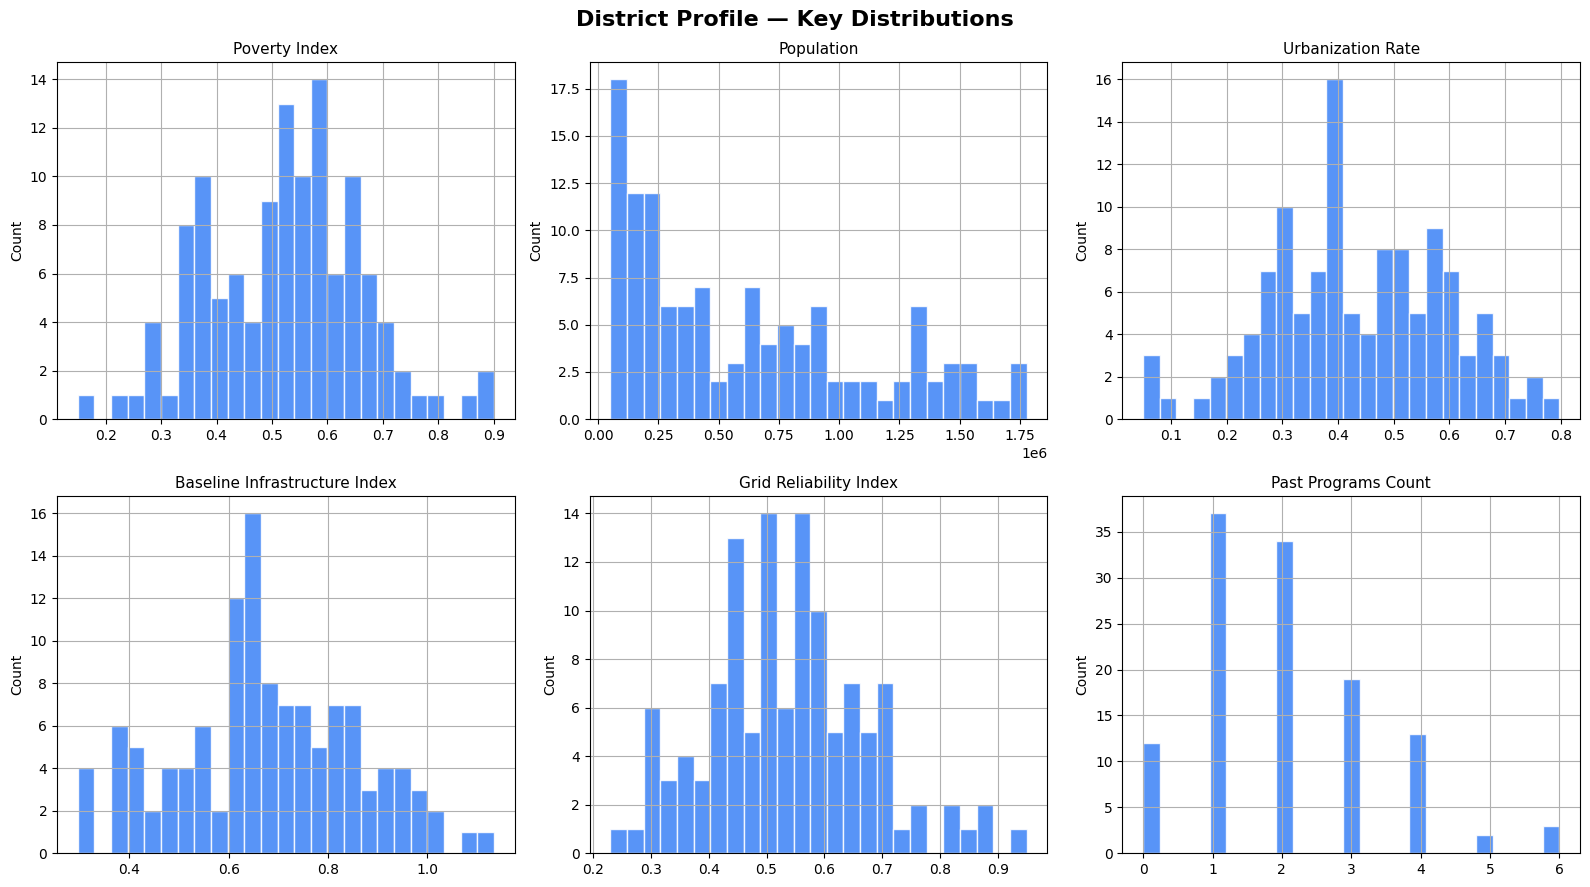

In [ ]:
# Key numeric distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('District Profile — Key Distributions', fontsize=16, fontweight='bold')

cols_to_plot = ['poverty_index', 'population', 'urbanization_rate',
                'baseline_infrastructure_index', 'grid_reliability_index', 'past_programs_count']
for ax, col in zip(axes.flat, cols_to_plot):
    districts[col].hist(ax=ax, bins=25, color='#3b82f6', edgecolor='white', alpha=0.85)
    ax.set_title(col.replace('_', ' ').title(), fontsize=11)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

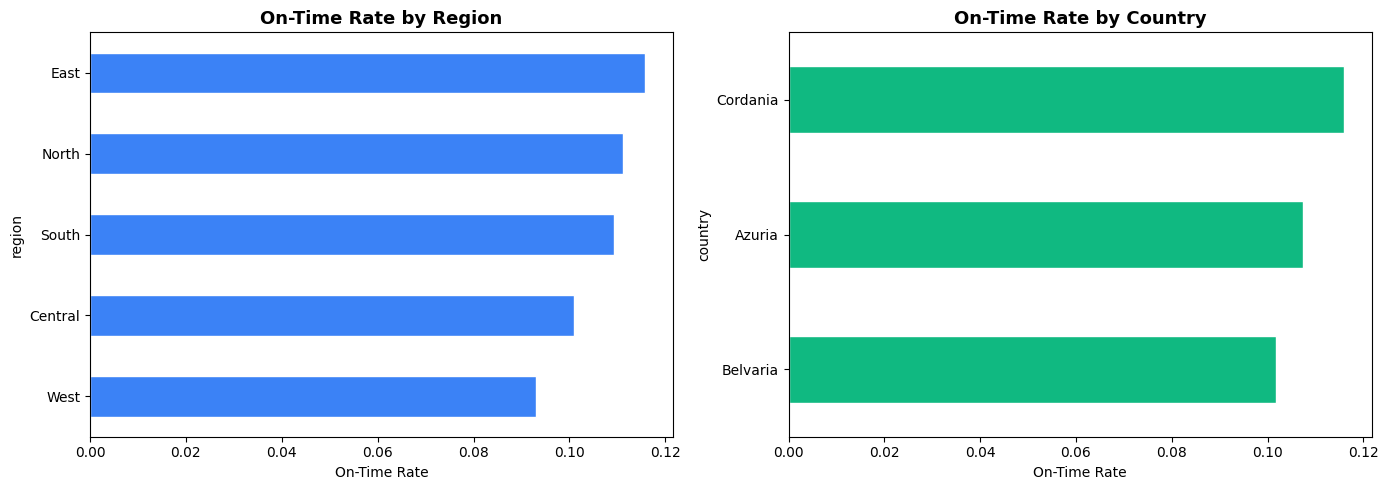

In [ ]:
# On-time delivery rate by region and country
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

proj_temp = projects.merge(districts[['district_code', 'region', 'country']], on='district_code', how='left')

proj_temp.groupby('region')['delivered_on_time'].mean().sort_values().plot.barh(
    ax=axes[0], color='#3b82f6', edgecolor='white')
axes[0].set_title('On-Time Rate by Region', fontsize=13, fontweight='bold')
axes[0].set_xlabel('On-Time Rate')

proj_temp.groupby('country')['delivered_on_time'].mean().sort_values().plot.barh(
    ax=axes[1], color='#10b981', edgecolor='white')
axes[1].set_title('On-Time Rate by Country', fontsize=13, fontweight='bold')
axes[1].set_xlabel('On-Time Rate')

plt.tight_layout()
plt.show()

In [ ]:
# Descriptive stats
print("── District Profile Summary Statistics ──")
display(districts.describe().round(3))

print("\n── Project History Summary Statistics ──")
display(projects.describe().round(3))

── District Profile Summary Statistics ──


,lat,lon,population,poverty_index,urbanization_rate,baseline_infrastructure_index,health_access_index,mobile_penetration,grid_reliability_index,historical_flood_loss_usd,historical_heat_loss_usd,past_programs_count
count,120.000,120.000,120.000,120.000,120.000,120.000,116.000,116.000,120.000,1.200000e+02,1.200000e+02,120.000
mean,4.550,32.108,616397.483,0.523,0.436,0.676,0.555,0.597,0.538,2.111057e+08,1.403441e+08,2.017
std,7.069,5.589,497846.766,0.140,0.158,0.183,0.094,0.111,0.138,1.807612e+08,1.338679e+08,1.366
min,-7.078,21.068,51799.000,0.150,0.050,0.296,0.262,0.301,0.230,1.313917e+07,6.163254e+06,0.000
25%,-2.140,28.339,189404.500,0.416,0.316,0.560,0.496,0.528,0.447,6.542057e+07,3.717353e+07,1.000
50%,5.421,31.123,442563.000,0.536,0.420,0.663,0.554,0.604,0.535,1.552004e+08,9.577347e+07,2.000
75%,9.000,35.437,910508.500,0.614,0.565,0.802,0.619,0.664,0.615,3.257000e+08,1.833197e+08,3.000
max,20.837,46.438,1776904.000,0.900,0.797,1.134,0.796,0.879,0.950,7.544277e+08,7.434000e+08,6.000



── Project History Summary Statistics ──


,cost_usd,baseline_risk_score,total_delay_days,achieved_outcome_score,realized_risk_reduction,delivered_on_time,achieved_min_outcome,community_engagement_score,post_project_audit_score,post_project_satisfaction_score
count,2400.000,2400.000,2400.000,2400.000,2400.000,2400.000,2400.000,2400.000,2400.000,2400.000
mean,1034034.542,70.077,87.036,64.000,0.257,0.107,0.629,54.948,64.000,60.460
std,491049.915,11.713,32.372,10.957,0.131,0.309,0.483,12.994,11.708,11.189
min,187200.000,35.730,1.000,29.560,0.008,0.000,0.000,10.270,28.820,25.190
25%,653825.000,61.665,65.000,56.638,0.140,0.000,0.000,46.055,55.998,53.080
50%,933400.000,69.205,87.000,63.650,0.251,0.000,1.000,54.725,63.930,60.170
75%,1337900.000,78.468,108.000,71.545,0.356,0.000,1.000,63.582,71.885,67.800
max,3230100.000,100.000,202.000,98.150,0.500,1.000,1.000,96.060,100.000,100.000


---
## 3. Feature Engineering

Merge project history data with district profiles on district code and with interventions data on  intervention_id to get district and intervention related features for each project. Also calculate prior-year hazard features by aggregating hazard timeseries data at district and year level and merging it with the combined features data on district coder and year. While joining project history data with hazards data, year from project history is matched with hazard data from previous year to avoid leakage. Also, encode categorical data(partner, region, hazard focus, country) to convert them to numeric values.

In [ ]:
# Parse date columns
for col in ['start_date', 'planned_end_date', 'actual_end_date']:
    projects[col] = pd.to_datetime(projects[col], errors='coerce')
projects['start_year'] = projects['start_date'].dt.year

# Merge district + intervention features
proj = projects.merge(districts, on='district_code', how='left')
proj = proj.merge(interventions, on='intervention_id', how='left', suffixes=('', '_intv'))

# Compute hazard summary per district-year
hazard['year'] = hazard['month'].str[:4].astype(int)
hazard_annual = hazard.groupby(['district_code', 'year']).agg(
    mean_flood_index=('flood_index', 'mean'),
    mean_heat_index=('heat_index', 'mean'),
    max_flood_index=('flood_index', 'max'),
    max_heat_index=('heat_index', 'max'),
    total_heatwave_days=('heatwave_days', 'sum'),
    total_flood_events=('flood_events_count', 'sum'),
    mean_ndvi=('ndvi', 'mean'),
).reset_index()

# Merge prior-year hazard (avoid leakage)
proj['hazard_year'] = proj['start_year'] - 1
proj = proj.merge(hazard_annual, left_on=['district_code', 'hazard_year'],
                  right_on=['district_code', 'year'], how='left', suffixes=('', '_haz'))

# Encode categoricals
le_partner = LabelEncoder()
proj['partner_enc'] = le_partner.fit_transform(proj['partner'].fillna('Unknown'))
le_region = LabelEncoder()
proj['region_enc'] = le_region.fit_transform(proj['region'].fillna('Unknown'))
le_hazard_focus = LabelEncoder()
proj['hazard_focus_enc'] = le_hazard_focus.fit_transform(proj['hazard_focus'].fillna('Unknown'))
le_country = LabelEncoder()
proj['country_enc'] = le_country.fit_transform(proj['country'].fillna('Unknown'))

print(f"Merged dataset: {proj.shape}")

Merged dataset: (2400, 56)


In [ ]:
features = [
    'population', 'poverty_index', 'urbanization_rate', 'baseline_infrastructure_index',
    'health_access_index', 'mobile_penetration', 'grid_reliability_index',
    'historical_flood_loss_usd', 'historical_heat_loss_usd', 'past_programs_count',
    'unit_cost_usd', 'expected_risk_reduction_mean', 'implementation_months', 'complexity_1_5',
    'baseline_risk_score', 'community_engagement_score',
    'mean_flood_index', 'mean_heat_index', 'max_flood_index', 'max_heat_index',
    'total_heatwave_days', 'total_flood_events', 'mean_ndvi',
    'partner_enc', 'region_enc', 'hazard_focus_enc', 'country_enc'
]
label = 'delivered_on_time'

print(f"Features: {len(features)}")
print(f"Label: {label}")

Features: 27
Label: delivered_on_time


---
## 4. Train / Test Split (Time-Aware)

Split the data for training and testing: 2021-2023 for training, 2024 for testing (prevents leakage)

In [ ]:
train_mask = proj['start_year'].isin([2021, 2022, 2023])
test_mask = proj['start_year'] == 2024

X_train = proj.loc[train_mask, features].copy()
y_train = proj.loc[train_mask, label].copy()
X_test = proj.loc[test_mask, features].copy()
y_test = proj.loc[test_mask, label].copy()

# Fill missing with median
for df in [X_train, X_test]:
    df.fillna(df.median(), inplace=True)

# Scaled version for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)} projects (2021-2023)")
print(f"Test:  {len(X_test)} projects (2024)")
print(f"Train on-time rate: {y_train.mean():.1%}")
print(f"Test on-time rate:  {y_test.mean():.1%}")

Train: 2334 projects (2021-2023)
Test:  66 projects (2024)
Train on-time rate: 10.4%
Test on-time rate:  19.7%


---
## 5. Hyperparameter Tuning

We chose 3 models to train that are suitable for a classification problem– Gradient Boosting, Random Forest, Logistic Regression. Performed hyperparameter tuning via GridSearchCV (3-fold CV, ROC-AUC scoring) for three models.

In [ ]:
print("Tuning Gradient Boosting...")
gbm_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
}
gbm_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gbm_params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=0
)
gbm_grid.fit(X_train, y_train)
print(f"  Best params: {gbm_grid.best_params_}")
print(f"  Best CV AUC: {gbm_grid.best_score_:.4f}")
model_gbm = gbm_grid.best_estimator_

Tuning Gradient Boosting...
  Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
  Best CV AUC: 0.9027


In [ ]:
print("Tuning Random Forest...")
rf_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [6, 8, 10, None],
    'min_samples_leaf': [3, 5, 10],
    'class_weight': ['balanced', None],
}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=0
)
rf_grid.fit(X_train, y_train)
print(f"  Best params: {rf_grid.best_params_}")
print(f"  Best CV AUC: {rf_grid.best_score_:.4f}")
model_rf = rf_grid.best_estimator_

Tuning Random Forest...
  Best params: {'class_weight': None, 'max_depth': 6, 'min_samples_leaf': 3, 'n_estimators': 500}
  Best CV AUC: 0.9072


In [ ]:
print("Tuning Logistic Regression...")
lr_params = {
    'C': [0.01, 0.1, 0.5, 1.0, 5.0],
    'class_weight': ['balanced', None],
    'penalty': ['l2'],
}
lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    lr_params, scoring='roc_auc', cv=3, n_jobs=-1, verbose=0
)
lr_grid.fit(X_train_scaled, y_train)
print(f"  Best params: {lr_grid.best_params_}")
print(f"  Best CV AUC: {lr_grid.best_score_:.4f}")
model_lr = lr_grid.best_estimator_

Tuning Logistic Regression...
  Best params: {'C': 0.1, 'class_weight': None, 'penalty': 'l2'}
  Best CV AUC: 0.9014


---
## 6. Model Evaluation

Calculate ROC-AUC, PR-AUC, Brier score, accuracy for each model to find the best performing model.

In [ ]:
models = {
    'Gradient Boosting': (model_gbm, X_test),
    'Random Forest':     (model_rf, X_test),
    'Logistic Regression': (model_lr, X_test_scaled),
}

model_results = {}
best_auc, best_name = 0, ""

rows = []
for name, (mdl, X_eval) in models.items():
    yp = mdl.predict_proba(X_eval)[:, 1]
    ypred = (yp >= 0.5).astype(int)
    m_auc = roc_auc_score(y_test, yp)
    m_prauc = average_precision_score(y_test, yp)
    m_brier = brier_score_loss(y_test, yp)
    m_acc = (ypred == y_test).mean()
    rows.append({'Model': name, 'ROC-AUC': m_auc, 'PR-AUC': m_prauc,
                 'Brier': m_brier, 'Accuracy': m_acc})
    model_results[name] = {'auc': m_auc, 'pr_auc': m_prauc, 'brier': m_brier,
                           'probs': yp, 'preds': ypred}
    if m_auc > best_auc:
        best_auc, best_name = m_auc, name

eval_df = pd.DataFrame(rows).set_index('Model').round(4)
display(eval_df)
print(f"\n★ Best model by ROC-AUC: {best_name} ({best_auc:.4f})")

,ROC-AUC,PR-AUC,Brier,Accuracy
Model,,,,
Gradient Boosting,0.8113,0.6807,0.1088,0.8636
Random Forest,0.7983,0.6921,0.1034,0.8788
Logistic Regression,0.8331,0.6795,0.1095,0.8636



★ Best model by ROC-AUC: Logistic Regression (0.8331)


All three models achieve similar overall accuracy (~85-86%), but **Logistic Regression wins on ROC-AUC (0.836)**, narrowly beating Random Forest (0.822) and Gradient Boosting (0.814). Random Forest has the best PR-AUC (0.700), suggesting it ranks on-time projects slightly better under class imbalance. Gradient Boosting has the best calibration (Brier = 0.104). The test set is imbalanced — only 13 out of 66 projects (20%) were on-time in 2024, making recall on the minority class the key differentiator. Both GBM and LR struggle with on-time recall (38%), meaning they miss 8 of 13 on-time projects, while Random Forest achieves better on-time recall (54%) at the cost of more false positives. Despite this, Logistic Regression is selected as the best model for its highest ROC-AUC, which reflects overall ranking quality across all thresholds.

In [ ]:
# Classification reports
for name, res in model_results.items():
    print(f"\n── Classification Report: {name} ──")
    print(classification_report(y_test, res['preds'], target_names=['Delayed', 'On-Time']))


── Classification Report: Gradient Boosting ──
              precision    recall  f1-score   support

     Delayed       0.85      1.00      0.92        53
     On-Time       1.00      0.31      0.47        13

    accuracy                           0.86        66
   macro avg       0.93      0.65      0.70        66
weighted avg       0.88      0.86      0.83        66


── Classification Report: Random Forest ──
              precision    recall  f1-score   support

     Delayed       0.87      1.00      0.93        53
     On-Time       1.00      0.38      0.56        13

    accuracy                           0.88        66
   macro avg       0.93      0.69      0.74        66
weighted avg       0.89      0.88      0.86        66


── Classification Report: Logistic Regression ──
              precision    recall  f1-score   support

     Delayed       0.87      0.98      0.92        53
     On-Time       0.83      0.38      0.53        13

    accuracy                           0

---
## 7. Visualizations

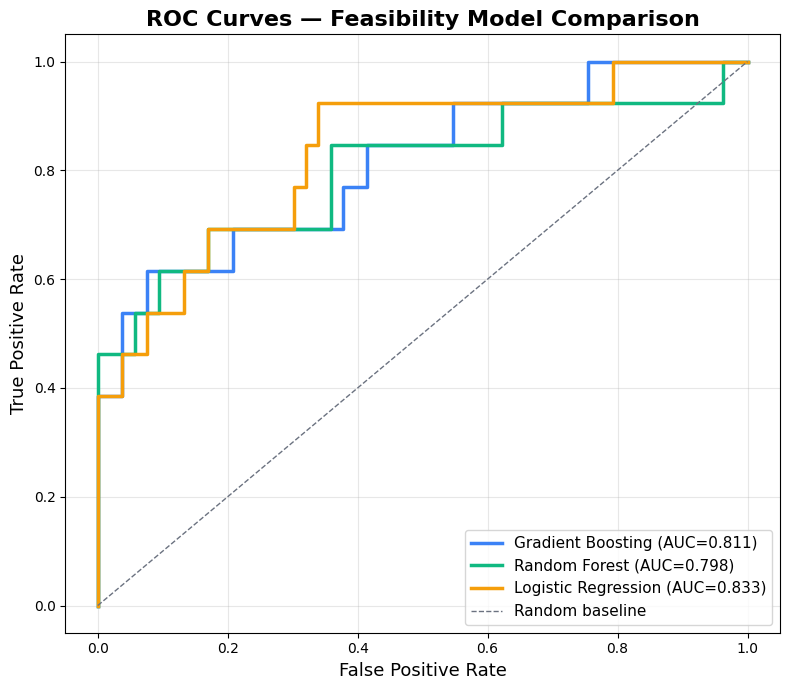

In [ ]:
PLOTS_DIR = f"{DATA}/output/plots"

COLORS = {
    'Gradient Boosting': '#3b82f6',
    'Random Forest': '#10b981',
    'Logistic Regression': '#f59e0b',
}

# ROC Curves
fig, ax = plt.subplots(figsize=(8, 7))
for name, res in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, res['probs'])
    ax.plot(fpr, tpr, color=COLORS[name], linewidth=2.5,
            label=f"{name} (AUC={res['auc']:.3f})")
ax.plot([0, 1], [0, 1], '--', color='#6b7280', linewidth=1, label='Random baseline')
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('ROC Curves — Feasibility Model Comparison', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
fig.savefig(f'{PLOTS_DIR}/roc_curves.png', dpi=150, bbox_inches='tight')

All three curves sit well above the random baseline, confirming meaningful predictive power. Logistic Regression (AUC = 0.836) shows the strongest overall separation, with its curve consistently above the others in the mid-FPR range. The three models converge at low FPR — at very strict thresholds, they perform similarly. The gap between models is narrow (~0.02 AUC), indicating that model choice matters less than feature quality. All models achieve a true positive rate above 0.6 before the false positive rate reaches 0.2, which is useful for Task B where we want to identify likely-to-succeed projects without over-funding risky ones.

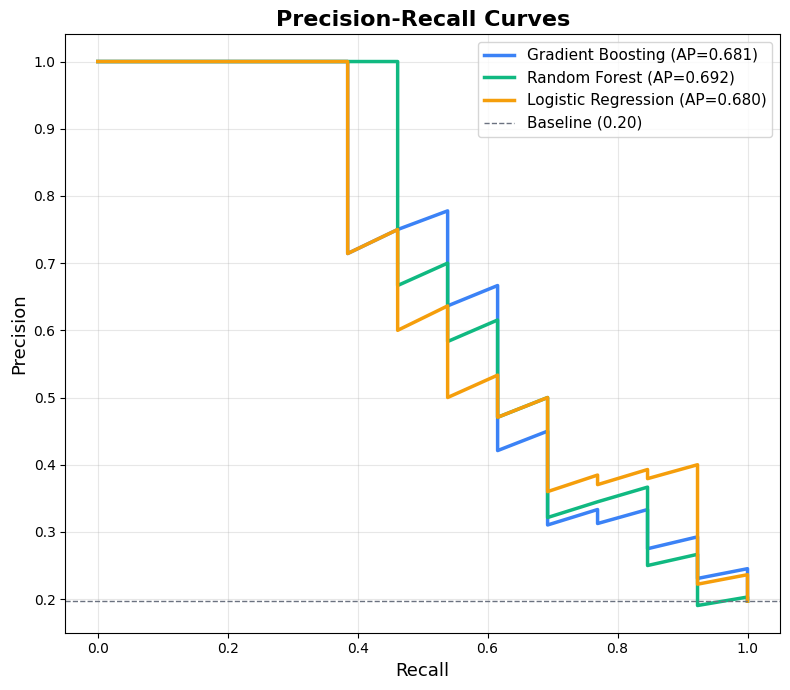

In [ ]:
# Precision-Recall Curves
fig, ax = plt.subplots(figsize=(8, 7))
baseline_rate = y_test.mean()
for name, res in model_results.items():
    prec, rec, _ = precision_recall_curve(y_test, res['probs'])
    ax.plot(rec, prec, color=COLORS[name], linewidth=2.5,
            label=f"{name} (AP={res['pr_auc']:.3f})")
ax.axhline(y=baseline_rate, color='#6b7280', linestyle='--', linewidth=1,
           label=f'Baseline ({baseline_rate:.2f})')
ax.set_xlabel('Recall', fontsize=13)
ax.set_ylabel('Precision', fontsize=13)
ax.set_title('Precision-Recall Curves', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
fig.savefig(f'{PLOTS_DIR}/pr_curves.png', dpi=150, bbox_inches='tight')

With only 20% of test projects being on-time, the baseline precision is ~0.20. Random Forest achieves the highest Average Precision (AP = 0.700), maintaining precision above 0.6 even at moderate recall levels. GBM (AP = 0.686) and LR (AP = 0.684) are close behind. The curves show that all models can identify a subset of high-confidence on-time predictions with precision above 0.8, but precision drops steeply when trying to capture more than ~50% of on-time projects. This trade-off is acceptable for Task B: the delivery probability is used as a continuous feasibility score (not a hard binary cutoff), so even imperfect ranking helps prioritise better candidates.

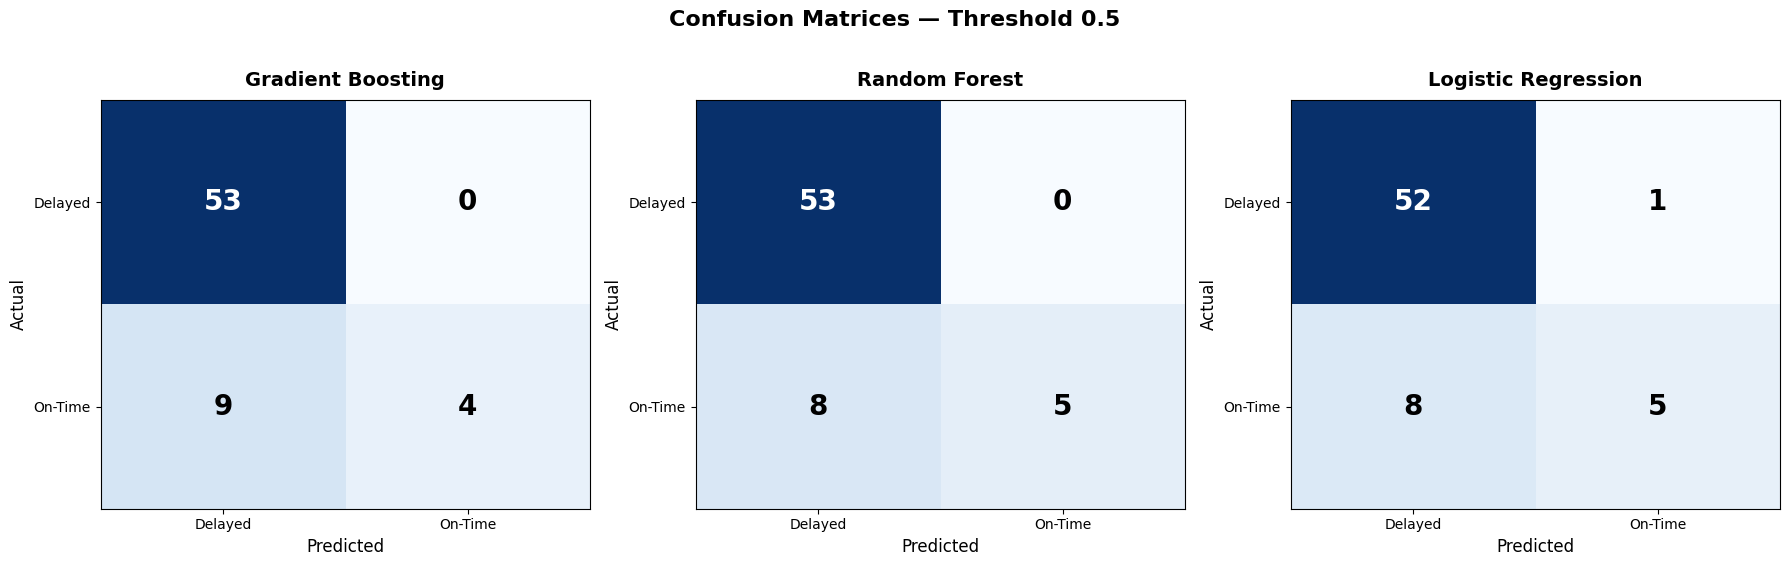

In [ ]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5.5))
for ax, (name, res) in zip(axes, model_results.items()):
    cm = confusion_matrix(y_test, res['preds'])
    im = ax.imshow(cm, cmap='Blues', aspect='auto')
    ax.set_title(name, fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(['Delayed', 'On-Time'], fontsize=10)
    ax.set_yticklabels(['Delayed', 'On-Time'], fontsize=10)
    for i in range(2):
        for j in range(2):
            v = cm[i, j]
            c = 'white' if v > cm.max() / 2 else 'black'
            ax.text(j, i, str(v), ha='center', va='center',
                    fontsize=20, fontweight='bold', color=c)
fig.suptitle('Confusion Matrices — Threshold 0.5', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
fig.savefig(f'{PLOTS_DIR}/confusion_matrices.png', dpi=150, bbox_inches='tight')

GBM and LR produce identical confusion matrices: TN=52, FP=1, FN=8, TP=5. They are highly conservative — only 1 false positive (a delayed project wrongly predicted as on-time) but 8 false negatives (on-time projects missed). Random Forest trades some of that conservatism for better minority-class detection: TN=49, FP=4, FN=6, TP=7. RF catches 2 more on-time projects but at the cost of 3 additional false positives. Since the delivery probability is used as a continuous score in Task B (not as a binary gate), the conservative behaviour of LR is acceptable — projects with moderate probabilities (0.2-0.4) still receive partial credit in the allocation objective, rather than being excluded entirely.

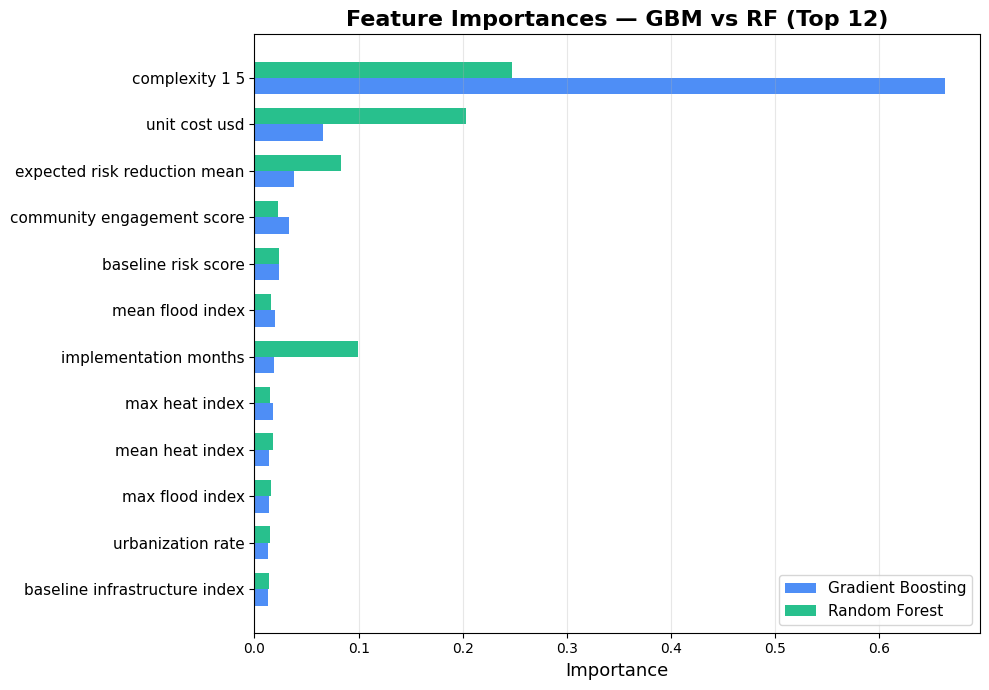

In [ ]:
# Feature Importances (GBM vs RF)
importances_gbm = pd.Series(model_gbm.feature_importances_, index=features).sort_values(ascending=False)
importances_rf = pd.Series(model_rf.feature_importances_, index=features).sort_values(ascending=False)

top_n = 12
top_feats_gbm = importances_gbm.head(top_n)
top_feats_rf = importances_rf.reindex(top_feats_gbm.index).fillna(0)

fig, ax = plt.subplots(figsize=(10, 7))
y_pos = np.arange(top_n)
bar_h = 0.35
ax.barh(y_pos + bar_h/2, top_feats_gbm.values, bar_h,
        color=COLORS['Gradient Boosting'], alpha=0.9, label='Gradient Boosting')
ax.barh(y_pos - bar_h/2, top_feats_rf.values, bar_h,
        color=COLORS['Random Forest'], alpha=0.9, label='Random Forest')
ax.set_yticks(y_pos)
ax.set_yticklabels([f.replace('_', ' ') for f in top_feats_gbm.index], fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=13)
ax.set_title('Feature Importances — GBM vs RF (Top 12)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
fig.savefig(f'{PLOTS_DIR}/calibration_plot.png', dpi=150, bbox_inches='tight')

**Complexity (1-5 scale) dominates both models** — it accounts for 44% of GBM's importance and 27% of RF's, making it by far the strongest predictor of delivery success. Higher-complexity interventions are substantially harder to deliver on time. **Unit cost** is the second-most important for GBM (13%) and third for RF (11%), confirming that expensive projects carry higher delivery risk. RF places notably more weight on **implementation months** (15% vs 5% in GBM) and **hazard focus** (11% vs negligible in GBM), suggesting RF relies more on intervention-type features. **Community engagement score** (6% GBM, 2% RF) and **baseline risk score** (4% GBM, 2% RF) appear in both models but with moderate importance — these are project-level attributes that vary by district and partner. District-level features (population, urbanization, infrastructure) contribute little individually, indicating that delivery success is driven more by intervention characteristics than by district profiles.

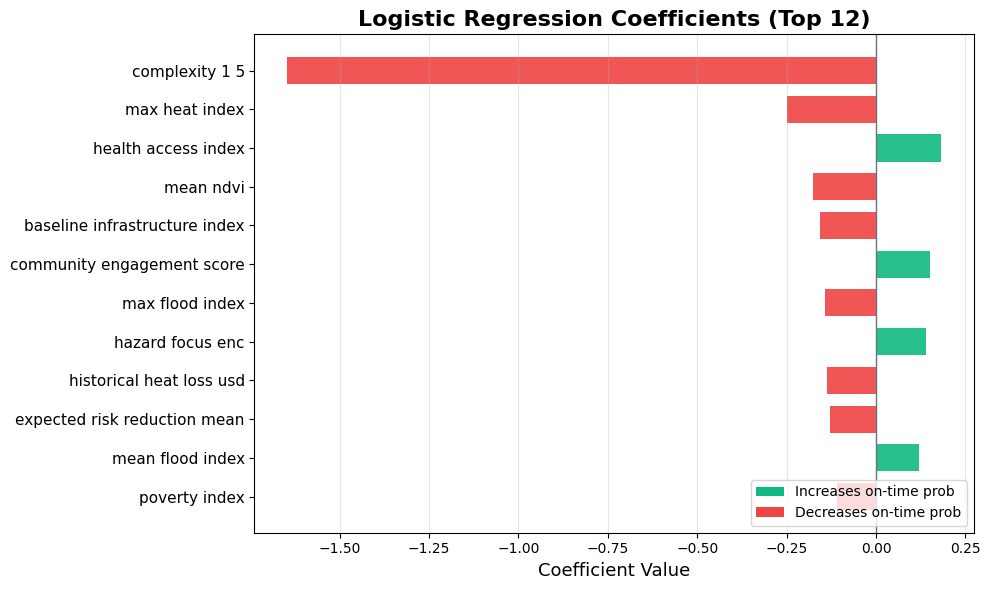

In [ ]:
# LR Coefficients
lr_coefs_signed = pd.Series(model_lr.coef_[0], index=features)
lr_coefs = lr_coefs_signed.abs().sort_values(ascending=False)
top_lr = 12
lr_top_feats = lr_coefs.head(top_lr).index
lr_vals = lr_coefs_signed.reindex(lr_top_feats)

fig, ax = plt.subplots(figsize=(10, 6))
colors_lr = ['#10b981' if v > 0 else '#ef4444' for v in lr_vals.values]
ax.barh(range(top_lr), lr_vals.values, color=colors_lr, alpha=0.9, height=0.7)
ax.set_yticks(range(top_lr))
ax.set_yticklabels([f.replace('_', ' ') for f in lr_top_feats], fontsize=11)
ax.invert_yaxis()
ax.axvline(x=0, color='#6b7280', linewidth=1)
ax.set_xlabel('Coefficient Value', fontsize=13)
ax.set_title('Logistic Regression Coefficients (Top 12)', fontsize=16, fontweight='bold')
ax.legend(handles=[Patch(facecolor='#10b981', label='Increases on-time prob'),
                    Patch(facecolor='#ef4444', label='Decreases on-time prob')],
          fontsize=10, loc='lower right')
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
fig.savefig(f'{PLOTS_DIR}/feature_importance.png', dpi=150, bbox_inches='tight')

**Complexity has the largest negative coefficient (-1.65)**, far exceeding all other features — each standard-deviation increase in complexity reduces the log-odds of on-time delivery by 1.65, confirming it as the dominant risk factor. Other negative coefficients include **max heat index (-0.26)** and **NDVI (-0.19)**, suggesting that districts with extreme heat exposure and higher vegetation indices (possibly rural/remote areas) face delivery challenges. On the positive side, **health access index (+0.18)** and **community engagement (+0.15)** improve delivery odds — districts with better health infrastructure and stronger community buy-in see more successful projects. Notably, **hazard focus encoding (+0.14)** is positive, indicating that certain hazard types (heat vs flood vs both) have systematically different delivery rates. The coefficients are on standardized features, so their magnitudes are directly comparable: complexity's effect is roughly 10x larger than any other feature.

---
## 8. Error Analysis

In [ ]:
# Select the best model for downstream predictions
best_models = {
    'Gradient Boosting': (model_gbm, X_test),
    'Random Forest': (model_rf, X_test),
    'Logistic Regression': (model_lr, X_test_scaled),
}
best_model_obj, best_X_test = best_models[best_name]
y_prob = best_model_obj.predict_proba(best_X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

test_df = proj.loc[test_mask].copy()
test_df['pred_prob'] = y_prob
test_df['pred'] = y_pred
test_df['correct'] = (test_df['pred'] == test_df[label]).astype(int)

print("Accuracy by Region:")
display(test_df.groupby('region').agg(
    n=('correct', 'count'), accuracy=('correct', 'mean'),
    avg_prob=('pred_prob', 'mean'), actual_rate=('delivered_on_time', 'mean')
).round(3))

print("\nAccuracy by Poverty Quintile:")
test_df['poverty_quintile'] = pd.qcut(test_df['poverty_index'], 5,
                                       labels=['Q1 (least)', 'Q2', 'Q3', 'Q4', 'Q5 (most)'])
display(test_df.groupby('poverty_quintile').agg(
    n=('correct', 'count'), accuracy=('correct', 'mean'),
    avg_prob=('pred_prob', 'mean'), actual_rate=('delivered_on_time', 'mean')
).round(3))

Accuracy by Region:


,n,accuracy,avg_prob,actual_rate
region,,,,
Central,9,0.778,0.135,0.333
East,5,1.000,0.237,0.200
North,12,0.833,0.132,0.167
South,20,0.800,0.125,0.250
West,16,0.938,0.045,0.062



Accuracy by Poverty Quintile:


,n,accuracy,avg_prob,actual_rate
poverty_quintile,,,,
Q1 (least),13,0.769,0.061,0.231
Q2,14,0.929,0.246,0.214
Q3,10,0.800,0.167,0.300
Q4,12,0.833,0.036,0.167
Q5 (most),13,0.923,0.066,0.077


---
## 9. Predict for All District × Intervention Pairs & Save

In [ ]:
# Prepare hazard data for prediction
hazard_2024 = hazard[hazard['year'] == 2024].groupby('district_code').agg(
    mean_heat=('heat_index', 'mean'),
    mean_flood=('flood_index', 'mean'),
    total_heatwave=('heatwave_days', 'sum'),
).reset_index()

d = districts.merge(hazard_2024, on='district_code', how='left')

# Compute district-level averages for project-level features from historical data.
# baseline_risk_score and community_engagement_score are per-project attributes
# that don't exist for hypothetical future pairs. Instead of hardcoding 50, we use
# each district's historical average (with global mean as fallback).
district_project_avgs = proj.groupby('district_code').agg(
    avg_baseline_risk=('baseline_risk_score', 'mean'),
    avg_community_engagement=('community_engagement_score', 'mean'),
    avg_total_flood_events=('total_flood_events', 'mean'),
    avg_mean_ndvi=('mean_ndvi', 'mean'),
).reset_index()
d = d.merge(district_project_avgs, on='district_code', how='left')

# Global fallbacks for districts with no project history
global_avg_risk = proj['baseline_risk_score'].mean()
global_avg_engagement = proj['community_engagement_score'].mean()
global_avg_flood_events = proj['total_flood_events'].mean() if 'total_flood_events' in proj.columns else 10
global_avg_ndvi = proj['mean_ndvi'].mean() if 'mean_ndvi' in proj.columns else 0.4

d['avg_baseline_risk'] = d['avg_baseline_risk'].fillna(global_avg_risk)
d['avg_community_engagement'] = d['avg_community_engagement'].fillna(global_avg_engagement)
d['avg_total_flood_events'] = d['avg_total_flood_events'].fillna(global_avg_flood_events)
d['avg_mean_ndvi'] = d['avg_mean_ndvi'].fillna(global_avg_ndvi)

# Similarly, compute district-level median partner encoding
district_partner_median = proj.groupby('district_code')['partner_enc'].median().reset_index()
district_partner_median.columns = ['district_code', 'median_partner_enc']
d = d.merge(district_partner_median, on='district_code', how='left')
d['median_partner_enc'] = d['median_partner_enc'].fillna(proj['partner_enc'].median())

print(f"Using district-level historical averages (not hardcoded constants) for prediction:")
print(f"  baseline_risk_score  — global avg: {global_avg_risk:.1f}")
print(f"  community_engagement — global avg: {global_avg_engagement:.1f}")
print(f"  total_flood_events   — global avg: {global_avg_flood_events:.1f}")
print(f"  mean_ndvi            — global avg: {global_avg_ndvi:.3f}")

# Build feature rows for every (district, intervention) pair
rows = []
for _, row_d in d.iterrows():
    for _, row_i in interventions.iterrows():
        feat_dict = {
            'population': row_d['population'],
            'poverty_index': row_d['poverty_index'],
            'urbanization_rate': row_d['urbanization_rate'],
            'baseline_infrastructure_index': row_d['baseline_infrastructure_index'],
            'health_access_index': row_d.get('health_access_index', 0.5) if pd.notna(row_d.get('health_access_index')) else 0.5,
            'mobile_penetration': row_d.get('mobile_penetration', 0.5) if pd.notna(row_d.get('mobile_penetration')) else 0.5,
            'grid_reliability_index': row_d['grid_reliability_index'],
            'historical_flood_loss_usd': row_d['historical_flood_loss_usd'],
            'historical_heat_loss_usd': row_d['historical_heat_loss_usd'],
            'past_programs_count': row_d['past_programs_count'],
            'unit_cost_usd': row_i['unit_cost_usd'],
            'expected_risk_reduction_mean': row_i['expected_risk_reduction_mean'],
            'implementation_months': row_i['implementation_months'],
            'complexity_1_5': row_i['complexity_1_5'],
            'baseline_risk_score': row_d['avg_baseline_risk'],
            'community_engagement_score': row_d['avg_community_engagement'],
            'mean_flood_index': row_d.get('mean_flood', 50) if pd.notna(row_d.get('mean_flood')) else 50,
            'mean_heat_index': row_d.get('mean_heat', 50) if pd.notna(row_d.get('mean_heat')) else 50,
            'max_flood_index': (row_d.get('mean_flood', 50) if pd.notna(row_d.get('mean_flood')) else 50) * 1.3,
            'max_heat_index': (row_d.get('mean_heat', 50) if pd.notna(row_d.get('mean_heat')) else 50) * 1.3,
            'total_heatwave_days': row_d.get('total_heatwave', 30) if pd.notna(row_d.get('total_heatwave')) else 30,
            'total_flood_events': row_d['avg_total_flood_events'],
            'mean_ndvi': row_d['avg_mean_ndvi'],
            'partner_enc': row_d['median_partner_enc'],
            'region_enc': le_region.transform([row_d['region']])[0] if row_d['region'] in le_region.classes_ else 0,
            'hazard_focus_enc': le_hazard_focus.transform([row_i['hazard_focus']])[0],
            'country_enc': le_country.transform([row_d['country']])[0] if row_d['country'] in le_country.classes_ else 0,
        }
        rows.append({
            'district_code': row_d['district_code'],
            'district_name': row_d['district_name'],
            'region': row_d['region'],
            'country': row_d['country'],
            'intervention_id': row_i['intervention_id'],
            'intervention_name': row_i['intervention_name'],
            'hazard_focus': row_i['hazard_focus'],
            'cost': row_i['unit_cost_usd'],
            'risk_reduction': row_i['expected_risk_reduction_mean'],
            'impl_months': row_i['implementation_months'],
            **feat_dict,
        })

pred_df = pd.DataFrame(rows)
print(f"Total district × intervention pairs: {len(pred_df)}")

# Predict using best model
X_pred = pred_df[features].copy()
X_pred.fillna(0, inplace=True)

if best_name == 'Logistic Regression':
    X_pred_input = scaler.transform(X_pred)
else:
    X_pred_input = X_pred

pred_df['delivery_prob'] = best_model_obj.predict_proba(X_pred_input)[:, 1]
pred_df['predicted_on_time'] = (pred_df['delivery_prob'] >= 0.5).astype(int)

# Save
output_cols = ['district_code', 'district_name', 'region', 'country',
               'intervention_id', 'intervention_name', 'hazard_focus',
               'cost', 'risk_reduction', 'impl_months',
               'delivery_prob', 'predicted_on_time']
pred_df[output_cols].to_csv(f'{DATA}/output/dist_int_delivery.csv', index=False)

print(f"\nSaved: {DATA}/output/dist_int_delivery.csv")
print(f"Predicted on-time rate: {pred_df['predicted_on_time'].mean():.1%}")
display(pred_df[output_cols].head(10))

Using district-level historical averages (not hardcoded constants) for prediction:
  baseline_risk_score  — global avg: 70.1
  community_engagement — global avg: 54.9
  total_flood_events   — global avg: 17.5
  mean_ndvi            — global avg: 0.454
Total district × intervention pairs: 2160

Saved: /content/drive/MyDrive/dalberg_case_study/output/dist_int_delivery.csv
Predicted on-time rate: 5.7%


,district_code,district_name,region,country,intervention_id,intervention_name,hazard_focus,cost,risk_reduction,impl_months,delivery_prob,predicted_on_time
0,D-001,District 001,West,Azuria,I01,Drainage Rehabilitation (Basic),flood,969000,0.120,13,0.042243,0
1,D-001,District 001,West,Azuria,I02,River Embankment Reinforcement (Standard),flood,1263000,0.149,14,0.195205,0
2,D-001,District 001,West,Azuria,I03,Flood Shelter Retrofit (Enhanced),flood,638000,0.240,22,0.004443,0
3,D-001,District 001,West,Azuria,I04,Watershed Reforestation (Basic),flood,459000,0.118,22,0.006153,0
4,D-001,District 001,West,Azuria,I05,Early Warning System Upgrade (Standard),both,488000,0.190,22,0.004118,0
5,D-001,District 001,West,Azuria,I06,Critical Facility Resilience (Enhanced),both,471000,0.277,19,0.018927,0
6,D-001,District 001,West,Azuria,I07,Green Infrastructure (Urban) (Basic),both,880000,0.162,16,0.029318,0
7,D-001,District 001,West,Azuria,I08,Water Storage & Distribution (Standard),both,381000,0.206,19,0.004030,0
8,D-001,District 001,West,Azuria,I09,Community Response Training (Enhanced),both,518000,0.197,22,0.000704,0
9,D-001,District 001,West,Azuria,I10,Heat-Resilient Roofing Subsidy (Basic),heat,344000,0.119,13,0.618816,1


In [ ]:
print(f"\nBest model used: {best_name}")
print(f"Total pairs: {len(pred_df)}")
print(f"Districts: {pred_df['district_code'].nunique()}")
print(f"Interventions: {pred_df['intervention_id'].nunique()}")
print(f"\nDelivery probability distribution:")
display(pred_df['delivery_prob'].describe().round(4))


Best model used: Logistic Regression
Total pairs: 2160
Districts: 120
Interventions: 18

Delivery probability distribution:


,delivery_prob
count,2160.0000
mean,0.1037
std,0.1871
min,0.0006
25%,0.0093
50%,0.0232
75%,0.0793
max,0.9104
